In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
import sys

sys.path.append("/global/homes/s/sfschen/Python/ZeldovichReconPk/")

In [3]:
from zeldovich_rsd_recon_fftw import Zeldovich_Recon

In [4]:
# power spectrum
sys.path.append('/global/homes/s/sfschen/Python/cosmoprimo/')
from cosmoprimo.fiducial import DESI

cosmo = DESI()

pkz = cosmo.get_fourier().pk_interpolator()
pk = pkz.to_1d(z=0.8)

kl = np.logspace(-3,1,2000)
pl = pk(kl)

In [6]:
# Linear Growth
sys.path.append('../')
from lss_likelihood.linear_theory import D_of_a, f_of_a

In [7]:
z = 0.8
OmegaM = cosmo['Omega_m']
fnu = cosmo['Omega_ncdm_tot'] / OmegaM

In [8]:
fz = f_of_a(1/(1+z), OmegaM=OmegaM) * (1-0.6*fnu)

In [9]:
# Run PT class
zelda = Zeldovich_Recon(kl,pl,R=10)

In [16]:
import time
t1 = time.time()
zelda.make_pltable(fz, D=1,\
                   kmin = 1e-3, kmax = 0.5, nk = 100,\
                   ngauss = 4, nmax=8, method = 'RecSym', a_perp = 1, a_par = 1);
t2 = time.time()
print(t2-t1)

142.61259698867798


In [10]:
def P0func(b1,b2,bs,alpha0_dd,alpha0_ds,sn):
    
    ret = zelda.p0ktable[:,0] + b1 * zelda.p0ktable[:,1] + b1**2*zelda.p0ktable[:,2] +\
          b2*zelda.p0ktable[:,3] + b1*b2*zelda.p0ktable[:,4] + b2**2*zelda.p0ktable[:,5] +\
          bs*zelda.p0ktable[:,6] + b1*bs*zelda.p0ktable[:,7] + b2*bs*zelda.p0ktable[:,8] + bs**2 * zelda.p0ktable[:,9] +\
          alpha0_dd * zelda.kv**2 * zelda.p0ktable[:,10] + alpha0_ds * zelda.kv**2 * zelda.p0ktable[:,11] + 1000*sn
        
    return ret

def P2func(b1,b2,bs,alpha2_dd, alpha2_ds, sn2):
    
    ret = zelda.p2ktable[:,0] + b1 * zelda.p2ktable[:,1] + b1**2*zelda.p2ktable[:,2] +\
          b2*zelda.p2ktable[:,3] + b1*b2*zelda.p2ktable[:,4] + b2**2*zelda.p2ktable[:,5] +\
          bs*zelda.p2ktable[:,6] + b1*bs*zelda.p2ktable[:,7] + b2*bs*zelda.p2ktable[:,8] + bs**2 * zelda.p2ktable[:,9] +\
          alpha2_dd * zelda.kv**2 * zelda.p2ktable[:,10] + alpha2_ds * zelda.kv**2 * zelda.p2ktable[:,11] + 1000 * sn2 * zelda.kv**2
        
    return ret

In [11]:
# Fit the data

In [12]:
pkdat = np.loadtxt('data/pkells_recsym_mean_cubic.dat')
cov   = np.loadtxt('data/pkells_recsym_cov_cubic.dat')
cinv = np.linalg.inv(cov)

(0.0, 0.3)

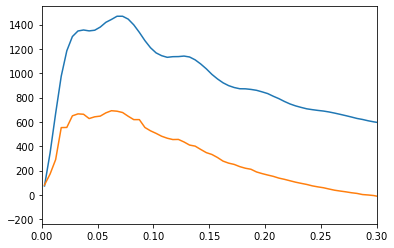

In [13]:
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1])
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,2])

plt.xlim(0,0.3)

In [15]:
kcen = pkdat[:,0]
dk = kcen[1] - kcen[0]
kr = kcen + dk/2
kl = kcen - dk/2
kmean = 3./4 * (kr**4 - kl**4) / (kr**3 - kl**3)

from scipy.interpolate import interp1d

def chi2(pars, kmax=0.3):
    
    b1,b2,bs,alpha0_dd,alpha0_ds,alpha2_dd,alpha2_ds, sn, sn2 = pars
    
    iis = (pkdat[:,0] < kmax) * (pkdat[:,0] > 0.02)
    
    p0 = interp1d(zelda.kv, P0func(b1,b2,bs,alpha0_dd, alpha0_ds, sn), kind='cubic', bounds_error=False)(kmean)
    p2 = interp1d(zelda.kv, P2func(b1,b2,bs,alpha2_dd, alpha2_ds, sn2), kind='cubic', bounds_error=False)(kmean)
    
    p0[~iis] = pkdat[~iis,1]
    p2[~iis] = pkdat[~iis,2]
    
    diff = np.concatenate((p0,p2)) - np.concatenate( (pkdat[:,1], pkdat[:,2]) )
    
    return np.dot(diff, np.dot(cinv, diff) ) + 100*bs**2

In [16]:
from scipy.optimize import minimize

In [17]:
x = minimize(chi2, [1,0,0,0,0,0,0,1,10]).x
b1,b2,bs,alpha0_dd,alpha0_ds,alpha2_dd,alpha2_ds, sn, sn2 = x

p0 = interp1d(zelda.kv, P0func(b1,b2,bs,alpha0_dd, alpha0_ds, sn), kind='cubic', bounds_error=False)(kmean)
p2 = interp1d(zelda.kv, P2func(b1,b2,bs,alpha2_dd, alpha2_ds, sn2), kind='cubic', bounds_error=False)(kmean)

(0.0, 0.3)

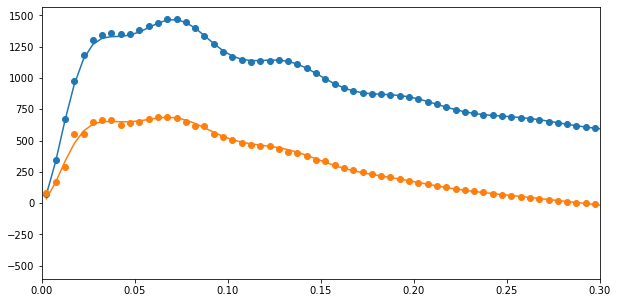

In [18]:
plt.figure(figsize=(10,5))

plt.plot(kcen, kcen * p0, 'C0')
plt.plot(kcen, kcen * p2, 'C1')

plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1], 'C0o')
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,2], 'C1o')

plt.xlim(0,0.3)



In [19]:
x

array([  0.98502816,   1.91563351,  -3.25576733,   0.51985208,
       -48.54374806, -11.44828705, -57.73503037,  -1.29062696,
        -2.84199229])

(-0.1, 0.1)

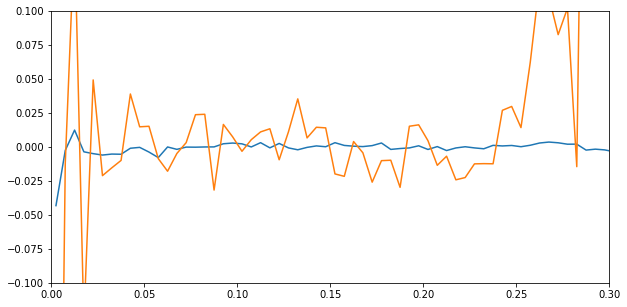

In [20]:
plt.figure(figsize=(10,5))

plt.plot(kcen, p0/pkdat[:,1] - 1, 'C0')
plt.plot(kcen, p2/pkdat[:,2] - 1, 'C1')

plt.xlim(0,0.3)

plt.ylim(-0.1,0.1)

In [21]:
from loginterp import loginterp
from spherical_bessel_transform import SphericalBesselTransform as SBT

In [22]:
xidat = np.loadtxt('data/xiells_recsym_mean_cubic.dat')

In [23]:
kint = zelda.kint
sbt = SBT(kint, fourier=True)

p0 = interp1d(zelda.kv, P0func(b1,b2,bs,alpha0_dd, alpha0_ds, sn), kind='cubic', bounds_error=False)(zelda.kv)
p2 = interp1d(zelda.kv, P2func(b1,b2,bs,alpha2_dd, alpha2_ds, sn2), kind='cubic', bounds_error=False)(zelda.kv)

p0 = loginterp(zelda.kv, p0)(kint)
p2 = loginterp(zelda.kv, p2)(kint)

qq0, xi0 = sbt.sph(0, p0 * np.exp(-kint**2))
qq2, xi2 = sbt.sph(2, p2 * np.exp(-kint**2)); xi2 *= -1

In function -  run_code


(-20.0, 100.0)

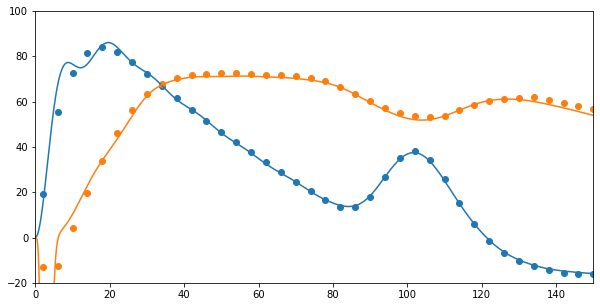

In [24]:
plt.figure(figsize=(10,5))

plt.plot(xidat[:,0], xidat[:,0]**2 * xidat[:,1], 'C0o')
plt.plot(xidat[:,0], -xidat[:,0]**2 * xidat[:,2], 'C1o')

plt.plot(qq0, qq0**2 * xi0)
plt.plot(qq0, -qq0**2 * xi2)

plt.xlim(0,150)
plt.ylim(-20,100)

In [25]:
# Now do some interpolations:

In [26]:
ptdat = np.zeros_like(pkdat)
ptdat[:,0] = pkdat[:,0]

for ii, k in enumerate(kcen):
    
    temp0 = interp1d(zelda.kv, P0func(b1,b2,bs,alpha0_dd, alpha0_ds, sn), kind='cubic', bounds_error=False, fill_value=0)
    temp2 = interp1d(zelda.kv, P2func(b1,b2,bs,alpha2_dd, alpha2_ds, sn2), kind='cubic', bounds_error=False, fill_value=0)
    
    rint = np.arange(0,1.01,0.01) * dk + (k - dk/2)
    
    ptdat[ii,1] = np.trapz(rint**2 * temp0(rint),x=rint) / np.trapz(rint**2, x=rint)
    ptdat[ii,2] = np.trapz(rint**2 * temp2(rint),x=rint) / np.trapz(rint**2, x=rint)

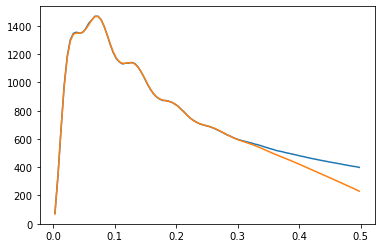

In [27]:
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1])
plt.plot(ptdat[:,0], ptdat[:,0] * ptdat[:,1])

In [28]:
#np.savetxt('data/pkells_recsym_theory.txt', ptdat)

In [29]:
rth = np.loadtxt('r_theory.txt')
binmat = np.loadtxt('binmat.txt')

xtdat = np.zeros_like(xidat)

xtdat[:,0] = xidat[:,0]
xtdat[:,1] = np.dot( binmat, interp1d(qq0, xi0, kind='cubic', fill_value=0, bounds_error=False)(rth) ) 
xtdat[:,2] = np.dot( binmat, interp1d(qq2, xi2, kind='cubic', fill_value=0, bounds_error=False)(rth) )

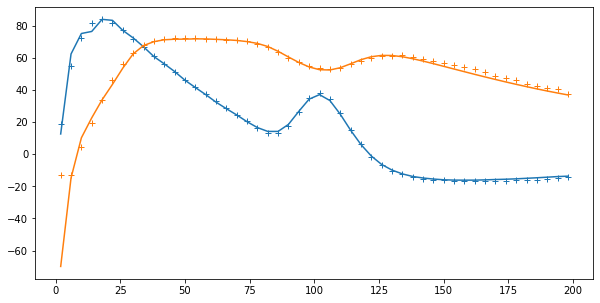

In [30]:
plt.figure(figsize=(10,5))

plt.plot(xidat[:,0], xidat[:,0]**2 * xidat[:,1], 'C0+')
plt.plot(xidat[:,0], xidat[:,0]**2 * xtdat[:,1], 'C0')

plt.plot(xidat[:,0], -xidat[:,0]**2 * xidat[:,2], 'C1+')
plt.plot(xidat[:,0], -xidat[:,0]**2 * xtdat[:,2], 'C1')

In [31]:
#np.savetxt('data/xiells_recsym_theory.txt', xtdat)